In [1]:
# pip install fastai

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from fastai import *
from fastai.text import *

In [2]:
import sklearn.feature_extraction.text as sklearn_text

### Tokenizing and document matrix creation
start wprking on a sample of data before using the full dataset-- allows quicker computations as we debug and get code working. Using IMDB sample:

In [4]:
path = untar_data(URLs.IMDB_SAMPLE)

In [5]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


usig [TextList](https://docs.fast.ai/text.data.html#TextList) from the fastai library

In [7]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                .split_from_df(col=2)
                .label_from_df(cols=0))

### Explore what data looks like
get a sense of what the data look like, in the example: movie reviews labeled as "positive" or "negative"

In [8]:
movie_reviews.valid.x[0], movie_reviews.valid.y[0]

(Text xxbos xxmaj this very funny xxmaj british comedy shows what might happen if a section of xxmaj london , in this case xxmaj xxunk , were to xxunk itself independent from the rest of the xxup uk and its laws , xxunk & post - war xxunk . xxmaj merry xxunk is what would happen . 
  
   xxmaj the explosion of a wartime bomb leads to the xxunk of ancient xxunk which show that xxmaj xxunk was xxunk to the xxmaj xxunk of xxmaj xxunk xxunk ago , a small historical xxunk long since forgotten . xxmaj to the new xxmaj xxunk , however , this is an unexpected opportunity to live as they please , free from any xxunk from xxmaj xxunk . 
  
   xxmaj stanley xxmaj xxunk is excellent as the minor city xxunk who suddenly finds himself leading one of the world 's xxunk xxunk . xxmaj xxunk xxmaj margaret xxmaj xxunk is a delight as the history professor who sides with xxmaj xxunk . xxmaj others in the stand - out cast include xxmaj xxunk xxmaj xxunk , xxmaj paul xxmaj xxunk , xxmaj xxunk xxmaj xxunk ,

All the tokenS starting with "xx" are fastai special tokens. List of all of them and meaning ([in the fastai docs](https://docs.fast.ai/text.transform.html))
The rules are all listed below, here is the meaning of the special tokens: 
- ```UNK``` (xxunk) is for an unknown word (one that isn't present in the current vocabulary)
- ```PAD``` (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch
- ```BOS``` (xxbos) represents the beginning of a text in your dataset
- ```FLD``` (xxfld) is used of you set ```mark_fields = True``` in your [TokenizeProcessor] to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)
- ```TK_MAJ``` (xxmaj) is used to indicate the next word begins with a capital in the original text
- ```TK_UP``` (xxup) is used to indicate the next word is written in all caps in the original text
- ```TK_REP``` (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n{char})
- ```TK_WREP```(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n{word})


In [20]:
print(f'There are {len(movie_reviews.train.x)} and {len(movie_reviews.valid.x)} reviews in the training and validations sets, respectively.')

There are 800 and 200 reviews in the training and validations sets, respectively.


movie_reviews.train is a LabelList object. <br>
movie_reviews.train.x is a TextList object that holds the reviews <br>
movie_reviews.train.y is a CategoryList object that holds the labels <br>

**The text of the movie review is stored as a character string, which contains the tokens separated by spaces. Here is the text of the first review:**

In [21]:
print(movie_reviews.train.x[0].text)
print(f'\nThere are {len(movie_reviews.train.x[0].text)} characters in the review')

xxbos xxmaj un - xxunk - believable ! xxmaj meg xxmaj ryan does n't even look her usual xxunk lovable self in this , which normally makes me forgive her shallow xxunk acting xxunk . xxmaj hard to believe she was the producer on this dog . xxmaj plus xxmaj kevin xxmaj kline : what kind of suicide trip has his career been on ? xxmaj xxunk ... xxmaj xxunk ! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a replay of xxmaj jonestown - hollywood style . xxmaj xxunk !

There are 511 characters in the review


**The text string can be split to get the list of tokens.**

In [22]:
print(movie_reviews.train.x[0].text.split())
print(f'\nThe review has {len(movie_reviews.train.x[0].text.split())} tokens')

['xxbos', 'xxmaj', 'un', '-', 'xxunk', '-', 'believable', '!', 'xxmaj', 'meg', 'xxmaj', 'ryan', 'does', "n't", 'even', 'look', 'her', 'usual', 'xxunk', 'lovable', 'self', 'in', 'this', ',', 'which', 'normally', 'makes', 'me', 'forgive', 'her', 'shallow', 'xxunk', 'acting', 'xxunk', '.', 'xxmaj', 'hard', 'to', 'believe', 'she', 'was', 'the', 'producer', 'on', 'this', 'dog', '.', 'xxmaj', 'plus', 'xxmaj', 'kevin', 'xxmaj', 'kline', ':', 'what', 'kind', 'of', 'suicide', 'trip', 'has', 'his', 'career', 'been', 'on', '?', 'xxmaj', 'xxunk', '...', 'xxmaj', 'xxunk', '!', '!', '!', 'xxmaj', 'finally', 'this', 'was', 'directed', 'by', 'the', 'guy', 'who', 'did', 'xxmaj', 'big', 'xxmaj', 'xxunk', '?', 'xxmaj', 'must', 'be', 'a', 'replay', 'of', 'xxmaj', 'jonestown', '-', 'hollywood', 'style', '.', 'xxmaj', 'xxunk', '!']

The review has 103 tokens


**The review tokens are numericalized, ie. mapped to integers. So a movie review is also stored as an array of integers:**

In [23]:
print(movie_reviews.train.x[0].data)
print(f'\nThe array contains {len(movie_reviews.train.x[0].data)} numericalized tokens')

[   2    5 4619   25 ...   10    5    0   52]

The array contains 103 numericalized tokens


### The Vocabulary

**The vocab object is a kind of reversible dictionary that translates back and forth between tokens and their integer representations. It has two methods of particular interest: stoi and itos, which stand for string-to-index and index-to-string**

- stoi: dictionary
- itos: list with integers for words ordered by frequency.
    - take less space to be stored
    - integers in a list are implicit


**In a defaultdict, rare words that appear fewer than three times in the corpus, and words that are not in the dictionary, are mapped to a default value, in this case, zero**

In [24]:
rare_words = ['acrid','a_random_made_up_nonexistant_word','acrimonious','allosteric','anodyne','antikythera']
for word in rare_words:
    print(movie_reviews.vocab.stoi[word])

0
0
0
0
0
0


Notice that ints-to-string (list) and string-to-ints (dict) have different lengths. Why?: Some words are mapped to unknown. Many will be mapped to capital. 

In [11]:
len(movie_reviews.vocab.itos), len(movie_reviews.vocab.stoi)

(6008, 19161)

In [25]:
print(f'len(stoi) = {len(movie_reviews.vocab.stoi)}')
print(f'len(itos) = {len(movie_reviews.vocab.itos)}')
print(f'len(stoi) - len(itos) = {len(movie_reviews.vocab.stoi) - len(movie_reviews.vocab.itos)}')

len(stoi) = 19166
len(itos) = 6008
len(stoi) - len(itos) = 13158


**This is because many words map to unknown. We can confirm here:**

In [26]:
unk = []
for word, num in movie_reviews.vocab.stoi.items():
    if num==0:
        unk.append(word)
len(unk)

13159

In [12]:
movie_reviews.vocab.itos[220:230]

['bit',
 'might',
 'things',
 'horror',
 'us',
 'almost',
 'may',
 'right',
 'must',
 'away']

In [17]:
movie_reviews.vocab.itos[6007]

'sollett'

In [18]:
movie_reviews.vocab.stoi['movie']

29

In [19]:
movie_reviews.vocab.itos[29]

'movie'

### Mapping movie reviews into vector space

**There are 6016 unique tokens in the IMDb review vocabulary. Their numericalized values range from 0 to 6015)**

In [27]:
print(f'There are {len(movie_reviews.vocab.itos)} unique tokens in the IMDb review sample vocabulary')
print(f'The numericalized token values run from {min(movie_reviews.vocab.stoi.values())} to {max(movie_reviews.vocab.stoi.values())} ')

There are 6008 unique tokens in the IMDb review sample vocabulary
The numericalized token values run from 0 to 6007 


**Each review can be mapped to a 6016-dimensional embedding vector whose indices correspond to the numericalized tokens, and whose values are the number of times the corresponding token appeared in the review. To do this efficiently we need to learn a bit about Counters.**

#### Counters
A **Counter** is a useful Python object. A Counter applied to a list returns an ordered dictionary whose keys are the unique elements in the list, and whose values are the counts of the unique elements. Counters are from the collections module (along with OrderedDict, defaultdict, deque, and namedtuple). Here is how Counters work:

**Let's make a TokenCounter for movie reviews**

In [29]:
TokenCounter = lambda review_index : Counter((movie_reviews.train.x)[review_index].data)
TokenCounter(0).items()

dict_items([(2, 1), (5, 15), (4619, 1), (25, 3), (0, 8), (867, 1), (52, 5), (3776, 1), (1800, 1), (95, 1), (37, 1), (85, 1), (191, 1), (64, 2), (935, 1), (2738, 1), (517, 1), (18, 1), (21, 3), (11, 1), (84, 1), (2417, 1), (192, 1), (88, 1), (3777, 1), (1801, 1), (127, 1), (10, 3), (269, 1), (15, 1), (273, 1), (73, 1), (26, 2), (9, 2), (1360, 1), (35, 2), (1213, 1), (1144, 1), (1145, 1), (2418, 1), (91, 1), (63, 1), (245, 1), (14, 2), (1361, 1), (1447, 1), (65, 1), (40, 1), (796, 1), (103, 1), (72, 2), (99, 1), (534, 1), (616, 1), (48, 1), (282, 1), (54, 1), (90, 1), (219, 1), (228, 1), (43, 1), (13, 1), (3778, 1), (3779, 1), (355, 1), (492, 1)])

**The TokenCounter keys are the numericalized tokens that apper in the review**

In [30]:
TokenCounter(0).keys()

dict_keys([2, 5, 4619, 25, 0, 867, 52, 3776, 1800, 95, 37, 85, 191, 64, 935, 2738, 517, 18, 21, 11, 84, 2417, 192, 88, 3777, 1801, 127, 10, 269, 15, 273, 73, 26, 9, 1360, 35, 1213, 1144, 1145, 2418, 91, 63, 245, 14, 1361, 1447, 65, 40, 796, 103, 72, 99, 534, 616, 48, 282, 54, 90, 219, 228, 43, 13, 3778, 3779, 355, 492])

**The TokenCounter values are the token multiplicities, i.e the number of times each token appears in the review**

In [32]:
TokenCounter(0).values()

dict_values([1, 15, 1, 3, 8, 1, 5, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Mapping movie reviews to embedding vectors
**Make a count_vectorizer function that represents a movie review as a 6016-dimensional embedding vector** <br>

**The indices of the embedding vector correspond to the n6016 numericalized tokens in the vocabulary; the values specify how often the corresponding token appears in the review.**

In [33]:
n_terms = len(movie_reviews.vocab.itos)
n_docs = len(movie_reviews.train.x)
make_token_counter = lambda review_index: Counter(movie_reviews.train.x[review_index].data)
def count_vectorizer(review_index,n_terms = n_terms,make_token_counter = make_token_counter):
    # input: review index, n_terms, and tokenizer function
    # output: embedding vector for the review
    embedding_vector = np.zeros(n_terms)        
    keys = list(make_token_counter(review_index).keys())
    values = list(make_token_counter(review_index).values())
    embedding_vector[keys] = values
    return embedding_vector

# make the embedding vector for the first review
embedding_vector = count_vectorizer(0)

**Here is the embedding vector for the first review in the training data set**

In [34]:
print(f'The review is embedded in a {len(embedding_vector)} dimensional vector')
embedding_vector

The review is embedded in a 6008 dimensional vector


array([8., 0., 1., 0., ..., 0., 0., 0., 0.])

### Create the document-term matrix for the IMDb
**In non-deep learning methods of NLP, we are often interested only in which words were used in a review, and how often each word got used. This is known as the bag of words approach, and it suggests a really simple way to store a document (in this case, a movie review).** <br>

**For each review we can keep track of which words were used and how often each word was used with a vector whose length is the number of tokens in the vocabulary, which we will call n. The indexes of this vector correspond to the tokens in the IMDb vocabulary, and thevalues of the vector are the number of times the corresponding tokens appeared in the review. For example the values stored at indexes 0, 1, 2, 3, 4 of the vector record the number of times the 5 tokens ['xxunk','xxpad','xxbos','xxeos','xxfld'] appeared in the review, respectively.** <br>

**Now, if our movie review database has m reviews, and each review is represented by a vector of length n, then vertically stacking the row vectors for all the reviews creates a matrix representation of the IMDb, which we call its document-term matrix. The rows correspond to documents (reviews), while the columns correspond to terms (or tokens in the vocabulary).** <br>
In the previous lesson, we used sklearn's CountVectorizer to generate the vectors that represent individual reviews. Today we will create our own (similar) version. This is for two reasons:

- to understand what sklearn is doing underneath the hood
- to create something that will work with a fastai TextList

**Form the embedding vectors for the movie_reviews in the training set and stack them vertically**

In [35]:
# Define a function to build the full document-term matrix
print(f'there are {n_docs} reviews, and {n_terms} unique tokens in the vocabulary')
def make_full_doc_term_matrix(count_vectorizer,n_terms=n_terms,n_docs=n_docs):
    
    # loop through the movie reviews
    for doc_index in range(n_docs):
        
        # make the embedding vector for the current review
        embedding_vector = count_vectorizer(doc_index,n_terms)    
            
        # append the embedding vector to the document-term matrix
        if(doc_index == 0):
            A = embedding_vector
        else:
            A = np.vstack((A,embedding_vector))
            
    # return the document-term matrix
    return A

# Build the full document term matrix for the movie_reviews training set
A = make_full_doc_term_matrix(count_vectorizer)

there are 800 reviews, and 6008 unique tokens in the vocabulary


**Explore the sparsity of the document-term matrix**

**The sparsity of a matrix is defined as the fraction of of zero-valued elements**

In [36]:
NNZ = np.count_nonzero(A)
sparsity = (A.size-NNZ)/A.size
print(f'Only {NNZ} of the {A.size} elements in the document-term matrix are nonzero')
print(f'The sparsity of the document-term matrix is {sparsity}')

Only 112405 of the 4806400 elements in the document-term matrix are nonzero
The sparsity of the document-term matrix is 0.976613473701731


**Using matplotlib's spy method, we can visualize the structure of the document-term matrix** <br>
spy plots the array, indicating each non-zero value with a dot.

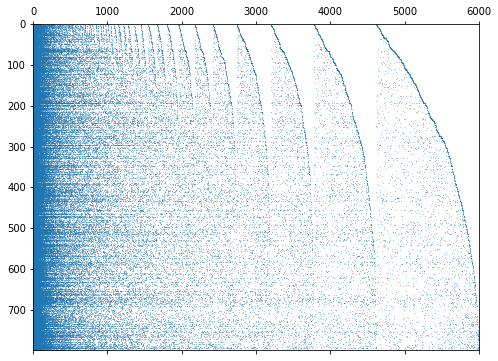

In [37]:
fig = plt.figure()
plt.spy(A, markersize=0.10, aspect = 'auto')
fig.set_size_inches(8,6)
fig.savefig('doc_term_matrix.png', dpi=800)

**Several observations stand out:**
1. Evidently, the document-term matrix is sparse ie. has a high proportion of zeros!
2. The density of the matrix increases toward the left edge. This makes sense because the tokens are ordered by usage frequency, with frequency increasing toward the left.
3. There is a perplexing pattern of curved vertical density ripples. <br>
**Next we'll see how to exploit matrix sparsity to save memory storage space, and compute time and resources.**

### Sparse Matrix Representation
**Even though we've reduced over 19,000 unique words in our corpus of reviews down to a vocabulary of 6,000 words, that's still a lot! But reviews are generally short, a few hundred words. So most tokens don't appear in a typical review. That means that most of the entries in the document-term matrix will be zeros, and therefore ordinary matrix operations will waste a lot of compute resources multiplying and adding zeros.** <br>

**We want to maximize the use of space and time by storing and performing matrix operations on our document-term matrix as a sparse matrix. scipy provides tools for efficient sparse matrix representatin and operations.** <br>

**Loosely speaking, matrix with a high proportion of zeros is called sparse (the opposite of sparse is dense). For sparse matrices, you can save a lot of memory by only storing the non-zero values.** <br>

**More specifically, a class of matrices is called sparse if the number of non-zero elements is proportional to the number of rows (or columns) instead of being proportional to the product rows x columns. An example is the class of diagonal matrices.** <br>

A matrix with lots of zeros is called **sparse** (the opposite of sparse is **dense**). For sparse matrices, you can save a lot of memory by only storing the non-zero values. <br>

There are the most common sparse storage formats: 
- coordinate-wise (scipy calls COO)
- compressed sparse row (CSR)
- compressed sparse column (CSC)